In [ ]:
# source: https://pennylane.ai/qml/demos/tutorial_kernels_module/
# Summary: evaluate kernels, use them for classification and train them with gradient-based optimization

Imports + Data
===================================

In [2]:
from pennylane import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.svm import SVC

In [18]:
# LOAD DATA 
X = np.loadtxt("trainX.txt")
Y = np.loadtxt("trainY.txt")
Y_train = np.where(Y == 0, -1.0, 1.0)

# X = X[:100]
# Y = Y[:100]

Quantum Kernel Circuit Construction
===================================

In [19]:
# CIRCUIT DESIGN:
# single layer construction: hadamard gate, z-axis rotation using data point x, y-axis rotation using parameters, control RZ gate ring
# q0: ──H──RZ(x[0])──RY(params[0, 0])───•─────────────
#                                       |
# q1: ──H──RZ(x[1])──RY(params[0, 1])───●───•─────────
#                                           |
# q2: ──H──RZ(x[2])──RY(params[0, 2])───────●─────────
# ansatz: repeats the above layer multiple times, using different parameters for each repetition

In [20]:
import pennylane as qml

def layer(x, params, wires, i0=0, inc=1):
    """Building block of the embedding ansatz"""
    i = i0
    for j, wire in enumerate(wires):
        qml.Hadamard(wires=[wire])
        qml.RZ(x[i % len(x)], wires=[wire])
        i += inc
        qml.RY(params[0, j], wires=[wire])

    qml.broadcast(unitary=qml.CRZ, pattern="ring", wires=wires, parameters=params[1])

To construct the ansatz, this layer is repeated multiple times, reusing
the datapoint `x` but feeding different variational parameters `params`
into each of them. Together, the datapoint and the variational
parameters fully determine the embedding ansatz $U(\boldsymbol{x})$. In
order to construct the full kernel circuit, we also require its adjoint
$U(\boldsymbol{x})^\dagger$, which we can obtain via `qml.adjoint`.


In [21]:
def ansatz(x, params, wires):
    """The embedding ansatz"""
    for j, layer_params in enumerate(params):
        layer(x, layer_params, wires, i0=j * len(wires))

adjoint_ansatz = qml.adjoint(ansatz)

Together with the ansatz we only need a device to run the quantum
circuit on. For the purpose of this tutorial we will use PennyLane\'s
`default.qubit` device with 5 wires in analytic mode.


In [22]:
dev = qml.device("default.qubit", wires=3, shots=None) 
wires = dev.wires.tolist()

Let us now define the quantum circuit that realizes the kernel. We will
compute the overlap of the quantum states by first applying the
embedding of the first datapoint and then the adjoint of the embedding
of the second datapoint. We finally extract the probabilities of
observing each basis state.


In [23]:
# Kernel Circuit: applies the ansatz for x1, applies the adjoint of the ansatz for x2, compute overlap between x1 and x2
@qml.qnode(dev)
def kernel_circuit(x1, x2, params):
    ansatz(x1, params, wires=wires)
    adjoint_ansatz(x2, params, wires=wires)
    return qml.probs(wires=wires)

The kernel function itself is now obtained by looking at the probability
of observing the all-zero state at the end of the kernel circuit --
because of the ordering in `qml.probs`, this is the first entry:


In [24]:
def kernel(x1, x2, params):
    return kernel_circuit(x1, x2, params)[0]

Before focusing on the kernel values we have to provide values for the
variational parameters. At this point we fix the number of layers in the
ansatz circuit to $6$.

In [40]:
def random_params(num_wires, num_layers):
    """Generate random variational parameters in the shape for the ansatz."""
    return np.random.uniform(0, 2 * np.pi, (num_layers, 2, num_wires), requires_grad=True)

init_params = random_params(num_wires=3, num_layers=2)
print(init_params)

[[[4.03679078 0.23481282 4.85470123]
  [1.08898985 4.30412059 0.25592845]]

 [[5.01875056 1.50830527 2.55906994]
  [4.55171666 4.27275021 4.95337798]]]


Now we can have a look at the kernel value between the first and the
second datapoint:


In [41]:
kernel_value = kernel(X[0], X[1], init_params)
print(f"The kernel value between the first and second datapoint is {kernel_value:.3f}")

The kernel value between the first and second datapoint is 0.720


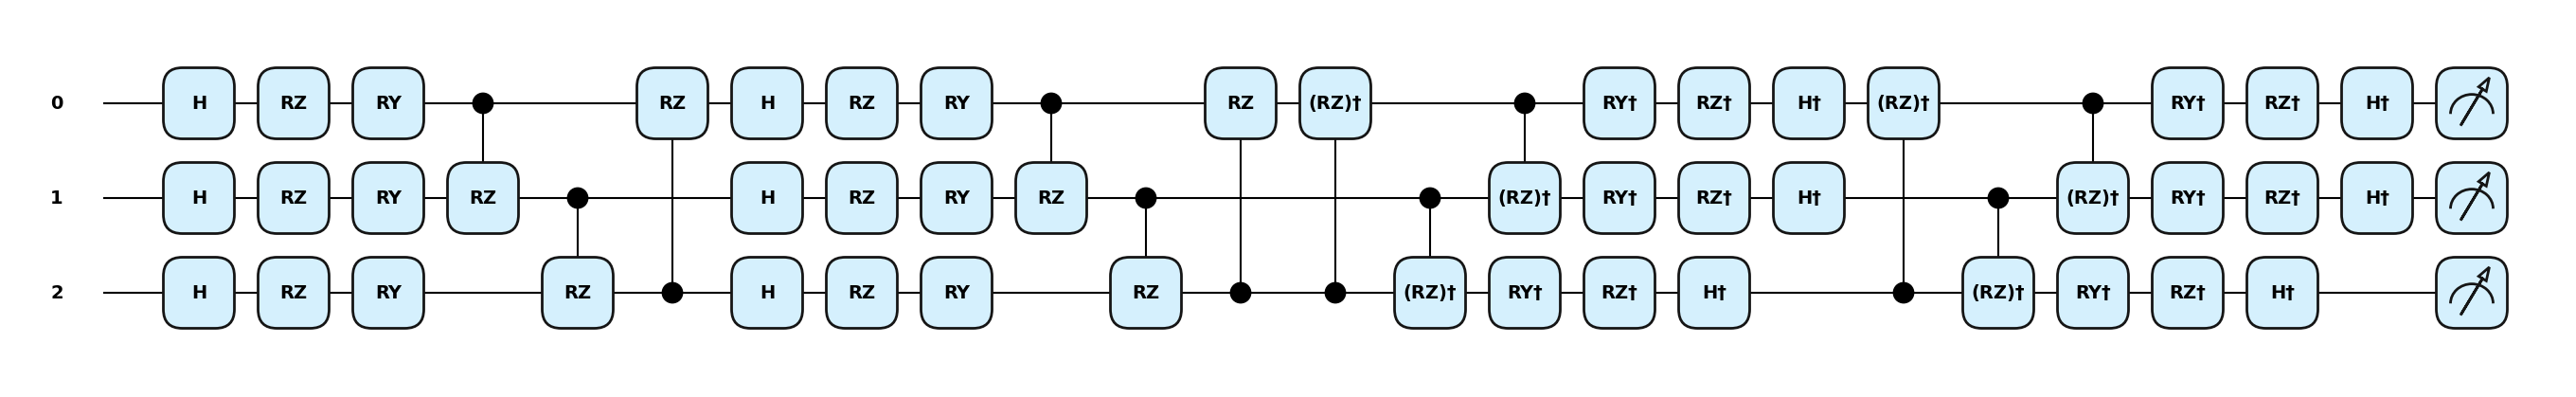

In [42]:
qml.draw_mpl(kernel_circuit, style='pennylane')(X[0], X[1], init_params)
plt.show()

The mutual kernel values between all elements of the dataset form the
*kernel matrix*. We can inspect it via the
`qml.kernels.square_kernel_matrix` method, which makes use of symmetry
of the kernel,
$k(\boldsymbol{x}_i,\boldsymbol{x}_j) = k(\boldsymbol{x}_j, \boldsymbol{x}_i)$.
In addition, the option `assume_normalized_kernel=True` ensures that we
do not calculate the entries between the same datapoints, as we know
them to be 1 for our noiseless simulation. Overall this means that we
compute $\frac{1}{2}(N^2-N)$ kernel values for $N$ datapoints. To
include the variational parameters, we construct a `lambda` function
that fixes them to the values we sampled above.


In [27]:
# import time
# start = time.time()

# init_kernel = lambda x1, x2: kernel(x1, x2, init_params)
# K_init = qml.kernels.square_kernel_matrix(X, init_kernel, assume_normalized_kernel=True)

# end = time.time()
# print("runtime in min: ", (end-start)/60)

# with np.printoptions(precision=3, suppress=True):
#     print(K_init)

Using the Quantum Embedding Kernel for predictions
==================================================

The quantum kernel alone can not be used to make predictions on a
dataset, becaues it is essentially just a tool to measure the similarity
between two datapoints. 

In [28]:
def accuracy(classifier, X, Y_target):
    return 1 - np.count_nonzero(classifier.predict(X) - Y_target) / len(Y_target)

In [29]:
# svm = SVC(kernel=lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, init_kernel)).fit(X, Y)
# accuracy_init = accuracy(svm, X, Y)
# print(f"The accuracy of the kernel with random parameters is {accuracy_init:.3f}")

In [30]:
def plot_decision_boundaries(classifier, ax, N_gridpoints=14):
    _xx, _yy = np.meshgrid(np.linspace(-1, 1, N_gridpoints), np.linspace(-1, 1, N_gridpoints))

    _zz = np.zeros_like(_xx)
    for idx in np.ndindex(*_xx.shape):
        _zz[idx] = classifier.predict(np.array([_xx[idx], _yy[idx]])[np.newaxis, :])

    plot_data = {"_xx": _xx, "_yy": _yy, "_zz": _zz}
    ax.contourf(
        _xx,
        _yy,
        _zz,
        cmap=mpl.colors.ListedColormap(["#FF0000", "#0000FF"]),
        alpha=0.2,
        levels=[-1, 0, 1],
    )
    plot_double_cake_data(X, Y, ax)

    return plot_data

Training the Quantum Embedding Kernel
==================================================

In [82]:
kta_init = qml.kernels.target_alignment(X, Y, init_kernel, assume_normalized_kernel=True)

print(f"The kernel-target alignment for our dataset and random parameters is {kta_init:.3f}")

The kernel-target alignment for our dataset and random parameters is 0.389


Now let\'s code up an optimization loop and improve the kernel-target
alignment!

We will make use of regular gradient descent optimization. To speed up
the optimization we will not use the entire training set to compute
$\operatorname{KTA}$ but rather sample smaller subsets of the data at
each step, we choose $4$ datapoints at random. Remember that
PennyLane\'s built-in optimizer works to *minimize* the cost function
that is given to it, which is why we have to multiply the kernel target
alignment by $-1$ to actually *maximize* it in the process.

Currently, the function `qml.kernels.target_alignment` is not
differentiable yet, making it unfit for gradient descent optimization.
We therefore first define a differentiable version of this function.

In [85]:
from pennylane.optimize import AdamOptimizer

def target_alignment(
    X,
    Y,
    kernel,
    assume_normalized_kernel=False,
    rescale_class_labels=True,
):
    """Kernel-target alignment between kernel and labels."""

    K = qml.kernels.square_kernel_matrix(
        X,
        kernel,
        assume_normalized_kernel=assume_normalized_kernel,
    )

    if rescale_class_labels:
        nplus = np.count_nonzero(np.array(Y) == 1)
        nminus = len(Y) - nplus
        _Y = np.array([y / nplus if y == 1 else y / nminus for y in Y])
    else:
        _Y = np.array(Y)

    T = np.outer(_Y, _Y)
    inner_product = np.sum(K * T)
    norm = np.sqrt(np.sum(K * K) * np.sum(T * T))

    # Check if norm is zero to avoid division by zero
    if norm == 0:
        return inner_product
    
    inner_product = inner_product / norm

    return inner_product


params = init_params
opt = qml.AdamOptimizer(0.01)
batch_size = 10

for i in range(250):
    # Choose subset of datapoints to compute the KTA on.
    subset = np.random.choice(list(range(len(X))), batch_size)
    # Define the cost function for optimization
    cost = lambda _params: -target_alignment(
        X[subset],
        Y[subset],
        lambda x1, x2: kernel(x1, x2, _params),
        assume_normalized_kernel=True,
    )
    # Optimization step
    params = opt.step(cost, params)

    # Report the alignment on the full dataset every 50 steps.
    if (i + 1) % 50 == 0:
        current_alignment = target_alignment(
            X,
            Y,
            lambda x1, x2: kernel(x1, x2, params),
            assume_normalized_kernel=True,
        )
        print(f"Step {i+1} - Alignment = {current_alignment:.3f}")

Step 25 - Alignment = 0.408
Step 50 - Alignment = 0.398
Step 75 - Alignment = 0.413
Step 100 - Alignment = 0.424
Step 125 - Alignment = 0.432
Step 150 - Alignment = 0.438
Step 175 - Alignment = 0.449
Step 200 - Alignment = 0.423
Step 225 - Alignment = 0.457
Step 250 - Alignment = 0.425


We want to assess the impact of training the parameters of the quantum
kernel. Thus, let\'s build a second support vector classifier with the
trained kernel:


In [86]:
import time
start = time.time()

# First create a kernel with the trained parameter baked into it.
trained_kernel = lambda x1, x2: kernel(x1, x2, params)

# Second create a kernel matrix function using the trained kernel.
trained_kernel_matrix = lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, trained_kernel)

# Note that SVC expects the kernel argument to be a kernel matrix function.
svm_trained = SVC(kernel=trained_kernel_matrix).fit(X, Y)

end = time.time()
print("runtime in min: ", (end-start)/60)

runtime in min:  28.81069133281708


We expect to see an accuracy improvement vs. the SVM with random
parameters:


In [87]:
accuracy_trained = accuracy(svm_trained, X, Y)
print(f"The accuracy of a kernel with trained parameters is {accuracy_trained:.3f}")

The accuracy of a kernel with trained parameters is 0.920


Now we inspect the decision boundaries of
our classifier:


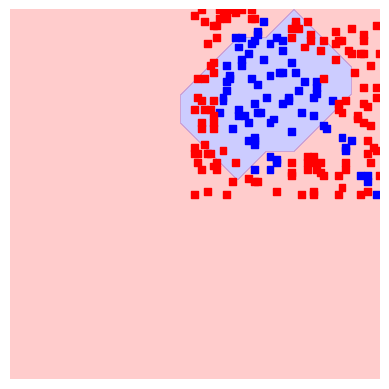

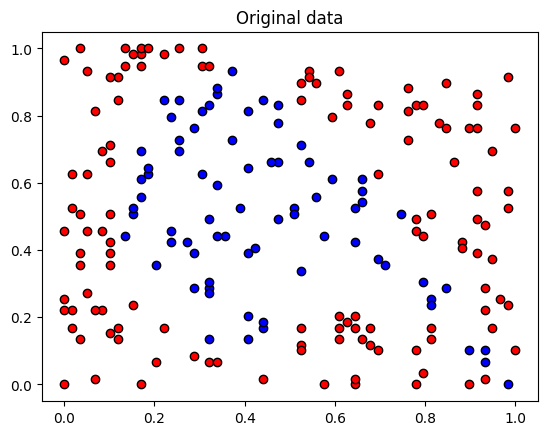

In [88]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X[:, 0][Y == 0], X[:, 1][Y == 0], c="r", marker="o", ec="k")
plt.title("Original data")
plt.show()

In [ ]:
init_plot_data = plot_decision_boundaries(svm, plt.gca())

Combining Classical NN - from Sijia
===================================

In [4]:
# def calAct(self, q_in, actmethod):
#     q_in = np.array(q_in)
#     if actmethod == 'tanh':
#         q_out = 2/(1+np.exp(-2*q_in))-1
#     elif actmethod == 'relu':
#         q_out = q_in*(q_in>0)
#     elif actmethod == 'sigmoid':
#         q_out = 1/(1+np.exp(-q_in))
        
#     return np.matrix(q_out)

# # classical neural network for optimizing the parameter 
# def param_compact(self, param, x_sample): # what is self? 
#     n_qubits = self.n_qubits
#     n_layers = self.n_layers
#     nQAOA = self.nQAOA 
#     n_x = 2 # number of features each input data sample has
#     """translate param_unaug from param
#     param_compact: n_layers * (2*n_qubits + 2*n_qubits)
#     param_qnn: n_layers * (2*n_qubits + 2*n_qubits*(n_x+1) )
#     """
#     param_m = np.matrix(param)
#     x_aug = np.matrix(np.concatenate((x_sample,[1]))).T

#     param_compact_ = np.matrix( np.zeros(( n_layers , nQAOA + n_qubits )) )
#     param_compact_[:,:nQAOA] = param_m[:,:nQAOA]

#     iindx = nQAOA
#     iindx_compact = nQAOA
#     for i_qubit in range(n_qubits): 
#         # in every layer, we have 2*n_qubit block for embedding x by activation function
#         # need to embed x to params for pennylane
#         # theoretically, 2*nq blocks are identical
#         q_in = param_m[:,iindx:(iindx+n_x+1)]*x_aug 
#         q_out = self.calAct(q_in, self.activation) # q_out = the output of the classical nn - input to the qnn instead of power data 
#         param_compact_[:,iindx_compact] = q_out 
#         iindx = iindx + n_x+1
#         iindx_compact = iindx_compact+1

#     # x_con = [0]
#     return np.array(param_compact_)

# def grad_augment(self, grad_compact, param , x_sample):
#     """
#     """
#     n_qubits = self.n_qubits
#     n_layers = self.n_layers
#     nQAOA = self.nQAOA
#     n_x = 2 
#     """translate grad from grad_aug
#     grad: n_layers * (2*n_qubits + 2*n_qubits)
#     grad_aug: n_layers * (2*n_qubits + 2*n_qubits*(n_x+1) )
#     """
#     #   grad_aug
#     param_m = np.matrix(param)
#     grad_compact = np.matrix(grad_compact)
#     x_aug = np.matrix(np.concatenate((x_sample,[1]))).T

#     grad_aug = np.matrix(np.zeros(param.shape))
#     grad_aug[:,:nQAOA] = grad_compact[:,:nQAOA]

#     iindx = nQAOA
#     iindx_compact = nQAOA
#     for i_qubit in range(2*n_qubits):
#         # in every layer, we have 2*n_qubit block for embedding x by activation function
#         # need to recalculate gradient for them
#         # theoretically, 2*nq blocks are identical

#         q_in = param_m[:,iindx:(iindx+n_x+1)]*x_aug
#         q_out = self.calAct_dev(q_in, self.activation)
#         grad_qout = np.multiply(grad_compact[:,iindx_compact],q_out)
#         grad_aug[:,iindx:(iindx+n_x+1)] = grad_qout*x_aug.T
#         # param_m_line = param_m[:,iindx:(iindx+n_x+1)].reshape(1,-1)[0][0]
#         # grad_aug_server[:,iindx:(iindx+n_x+1)] = grad_qout*param_m_line[0,iindx_server:iindx_server+n_x+1]

#         iindx = iindx + n_x+1
#         iindx_compact = iindx_compact+1

#     return np.array(grad_aug)

In [ ]:
# Define the Quantum Kernel Optimizer
class QuantumKernelOptimizer:
    def __init__(self, n_qubits, n_layers, n_x, activation='tanh'):
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.n_x = n_x # number of features each input data sample has
        self.activation = activation

    def calAct(self, q_in, actmethod):
        q_in = np.array(q_in)
        if actmethod == 'tanh':
            q_out = 2 / (1 + np.exp(-2 * q_in)) - 1
        elif actmethod == 'relu':
            q_out = q_in * (q_in > 0)
        elif actmethod == 'sigmoid':
            q_out = 1 / (1 + np.exp(-q_in))
        return np.matrix(q_out)

    def param_compact(self, param, x_sample):
        n_qubits = self.n_qubits
        n_layers = self.n_layers
        n_x = self.n_x
        param_m = np.matrix(param)
        x_aug = np.matrix(np.concatenate((x_sample, [1]))).T
        param_compact_ = np.matrix(np.zeros((n_layers, n_qubits)))
        param_compact_[:, :n_qubits] = param_m[:, :n_qubits]

        iindx = n_qubits
        for i_qubit in range(n_qubits):
            q_in = param_m[:, iindx:(iindx + n_x + 1)] * x_aug
            q_out = self.calAct(q_in, self.activation)
            param_compact_[:, iindx] = q_out
            iindx = iindx + n_x + 1

        return np.array(param_compact_)

    def grad_augment(self, grad_compact, param, x_sample):
        n_qubits = self.n_qubits
        n_layers = self.n_layers
        n_x = self.n_x
        
        # translate grad from grad_aug
        # grad: n_layers * (n_qubits + n_qubits)
        # grad_aug: n_layers * (n_qubits + n_qubits*(n_x+1) )
        
        #   grad_aug
        param_m = np.matrix(param)
        grad_compact = np.matrix(grad_compact)
        x_aug = np.matrix(np.concatenate((x_sample,[1]))).T
    
        grad_aug = np.matrix(np.zeros(param.shape))
        grad_aug[:,:nQAOA] = grad_compact[:,:nQAOA]
    
        iindx = n_qubits
        for i_qubit in range(n_qubits):
            # in every layer, we have n_qubit block for embedding x by activation function
            # need to recalculate gradient for them
            q_in = param_m[:,iindx:(iindx+n_x+1)]*x_aug
            q_out = self.calAct_dev(q_in, self.activation)
            grad_qout = np.multiply(grad_compact[:,iindx_compact],q_out)
            grad_aug[:,iindx:(iindx+n_x+1)] = grad_qout*x_aug.T
            iindx = iindx + n_x+1
    
        return np.array(grad_aug)

In [5]:
def train(self, param, x_sample, y_sample, epochs, learning_rate):
    for epoch in range(epochs):
        param_compact = self.param_compact(param, x_sample)
        predictions = self.kernel(x_sample, x_sample, param_compact)
        loss = np.mean((predictions - y_sample) ** 2)
        
        # Backpropagation and parameter update
        grad = self.grad_augment(param_compact, param, x_sample)
        param -= learning_rate * grad

    return param

In [ ]:
# Use the optimized kernel
def optimized_kernel(x1, x2, x_sample):
    optimized_params = optimizer.param_compact(init_params, x_sample)
    return kernel(x1, x2, optimized_params)

In [ ]:
optimizer = QuantumKernelOptimizer(n_qubits=5, n_layers=6, n_x=3)

# Evaluate the kernel with optimized parameters
K_optimized = qml.kernels.square_kernel_matrix(X, lambda x1, x2: optimized_kernel(x1, x2, x_sample=X[0]), assume_normalized_kernel=True)

print("Optimized Kernel Matrix:", K_optimized)